# *import*

In [1]:
# from collections import OrderedDict
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
from datasets.utils.logging import enable_progress_bar
enable_progress_bar()
import time
import threading
import random
import os
import torch


import flwr
from flwr.client import Client, ClientApp
from flwr.common import ndarrays_to_parameters, Context, Metrics
from flwr.server import ServerApp, ServerConfig, ServerAppComponents

from flwr.simulation import run_simulation

from utils.model_CNN import Net
from utils.model_CNN import SVHNNet
from utils.model_CNN import ConvNet
from utils.train_test import test
from utils.loaddata import get_cached_datasets
from utils.others import get_parameters, set_parameters, evaluate_and_plot_confusion_matrix, weighted_average


from utils.history import history
from utils.client import FlowerClient
from utils.clientmanger import DynamicClientManager
from utils.HRFA_strategy import HRFA
from utils.other_strategy import AdaFedAdamStrategy, MyFedAvg
from utils.dynamic_controll import background_online_offline_simulator


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
# disable_progress_bar()

Training on cuda
Flower 1.17.0 / PyTorch 2.5.1+cu124


# **Load Data**

In [2]:
NUM_CLIENTS = 10
NUM_ROUNDS = 20
NUM_EPOCHS = 5
ATTACK_TYPE = "UPA"
DFL = False
STRATEGY = "HRFA"  # 可選 "FedAvg", "AdaFedAdam", "HRFA"

DATASET = "mnist" #"mnist", "cifar10", "svhn", "fashion_mnist"

# 攻擊者模式設定
ATTACK_MODE = "progressive"  # "fixed": 固定攻擊者數量, "progressive": 攻擊者漸漸變多
ATTACK_INCREASE_ROUNDS = NUM_ROUNDS*0.9  # 僅在 progressive 模式下使用：在前多少輪中逐漸增加攻擊者

#dynamic experiment
if DATASET == "cifar10":
    FRACTION = 0.6
    Q = 0.7
    ATTACK_NUMS = NUM_CLIENTS*0.28
    # ATTACK_NUMS = 0
    Net = ConvNet
elif DATASET == "fashion_mnist":
    FRACTION = 0.5
    Q = 0.8
    ATTACK_NUMS = NUM_CLIENTS*0.28
    # ATTACK_NUMS = 0
    Net = ConvNet
#static experiment
elif DATASET == "mnist":
    FRACTION = 1.0
    Q = 0.0
    # ATTACK_NUMS = (NUM_CLIENTS//2)-1
    ATTACK_NUMS = 2
    Net = Net
else :
    FRACTION = 1.0
    Q = 0.9
    ATTACK_NUMS = (NUM_CLIENTS//2)-1
    # ATTACK_NUMS = 0
    Net = SVHNNet


In [3]:
# trainloader, _, _ = get_cached_datasets(partition_id=0, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)
# batch = next(iter(trainloader))
# images, labels = batch["img"], batch["label"]

# # Reshape and convert images to a NumPy array
# # matplotlib requires images with the shape (height, width, 3)
# images = images.permute(0, 2, 3, 1).numpy()

# # Denormalize
# images = images / 2 + 0.5

# # Create a figure and a grid of subplots
# fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# # Loop over the images and plot them
# for i, ax in enumerate(axs.flat):
#     ax.imshow(images[i])
#     ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    
#     ax.axis("off")

# # Show the plot
# fig.tight_layout()
# plt.show()

In [4]:
current_server_round = 0
new_round_event = threading.Event()

def get_current_round() -> int:
    return current_server_round

# **Client**

In [5]:
def client_fn(context: Context) -> Client:
    # Load model
    net = Net().to(DEVICE, memory_format=torch.channels_last)
    
	# Read the node_config to fetch data partition associated to this node
    partition_id = str(context.node_config["partition-id"])  # 強制轉換為字串
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = get_cached_datasets(partition_id, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)

    if int(partition_id) < ATTACK_NUMS:
        return FlowerClient(partition_id, net, trainloader, valloader, ATTACK_TYPE, ATTACK_NUMS, ATTACK_MODE, ATTACK_INCREASE_ROUNDS).to_client()
    else:
        return FlowerClient(partition_id, net, trainloader, valloader).to_client()

# Create the ClientApp
client = ClientApp(client_fn=client_fn)

# **Server**

### setting

In [6]:
def server_evaluate(server_round, parameters, config):
    global current_server_round
    # 更新全域變數，讓背景執行緒知道目前是第幾個 round
    current_server_round = server_round
    """Evaluate the global model after each round (不再畫 confusion matrix)."""
    start_time = time.time()  # 記錄開始時間
    net = Net().to(DEVICE)
    set_parameters(net, parameters)

    # 加載測試集
    _, _, testloader = get_cached_datasets(0, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)

    # 測試
    loss, accuracy = test(net, testloader)
    
    end_time = time.time()  # 記錄結束時間
    round_time = end_time - start_time  # 計算 round 時間
    
    history.add_loss_centralized(server_round, loss)
    history.add_metrics_centralized(server_round, {"accuracy": accuracy})

    # 只記錄最終模型，不畫 confusion matrix
    if server_round == NUM_ROUNDS:  # 最後一輪才返回模型
        evaluate_and_plot_confusion_matrix(net, testloader, DEVICE)
        return loss, {"accuracy": accuracy}
    new_round_event.set()
    return loss, {"accuracy": accuracy}


In [7]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        # "local_epochs": 1 if server_round < 2 else NUM_EPOCHS,
        "local_epochs": NUM_EPOCHS,
        "train_mode": "lookahead", #no use
    }
    return config

In [8]:
params = get_parameters(Net())
param_count = sum(p.numel() for p in Net().parameters() if p.requires_grad)
print(f"Trainable Parameters: {param_count:,d}")

if STRATEGY == "AdaFedAdam":
    print("Using AdaFedAdam strategy")
    strategy = AdaFedAdamStrategy(
        fraction_fit=FRACTION,
        fraction_evaluate=FRACTION,
        
        min_fit_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_evaluate_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_available_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數

        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=server_evaluate,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=fit_config,
        net=Net().to(DEVICE),
    )
elif STRATEGY == "FedAvg":
    print("Using FedAvg strategy")
    strategy = MyFedAvg(
        fraction_fit=FRACTION,
        fraction_evaluate=FRACTION,
        
        min_fit_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_evaluate_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_available_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數

        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=server_evaluate,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=fit_config,
    )
else:
    print("Using HRFA strategy")
    strategy = HRFA(
        fraction_fit=FRACTION,  # Sample 100% of available clients for training
        fraction_evaluate=FRACTION,  # Sample 50% of available clients for evaluation
        
        min_fit_clients=2,  # Never sample less than 10 clients for training
        min_evaluate_clients=2,  # Never sample less than 5 clients for evaluation
        min_available_clients=2,  # Wait until all 10 clients are available
        
        initial_parameters=ndarrays_to_parameters(params),  # Pass initial model parameters
        evaluate_fn=server_evaluate,  # 設定 evaluate_fn
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
        on_fit_config_fn=fit_config,  # Pass the fit_config function
        on_evaluate_config_fn=fit_config,
        net=Net().to(DEVICE),
        # testloader = testloader,
    )


Trainable Parameters: 620,810
Using HRFA strategy


### Define Server

In [9]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""
    global testloader

    # 設定 ServerConfig，如同你的程式碼
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    # 建立動態管理器
    client_manager = DynamicClientManager()
        
    # 建立並啟動背景執行緒，模擬客戶端動態上/下線
    simulator_thread = threading.Thread(
        target=background_online_offline_simulator,
        args=(client_manager, get_current_round, new_round_event, 0.5, 0.5, DFL),  # interval=30秒, toggle_rate=0.3
        daemon=True  # 設 daemon=True 可以在主程式結束時自動退出
    )
    simulator_thread.start()

    return ServerAppComponents(
        strategy=strategy,
        config=config,
        client_manager=client_manager,
    )


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# *Run simulation*

### Run setting

In [10]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 2 , 
                                           "num_gpus": 0.2 #if (NUM_CLIENTS*FRACTION)>40 else 2/(NUM_CLIENTS*FRACTION)
                                          }}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


[Status] Client 13342362300736246525 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 16682878904018580990 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 14280421594330983521 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 820025475804145417 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 11578944637461812264 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 9177805072210191156 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 14273237587208524874 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 14177003460850585197 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 11735101587018311025 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 1642605340384820759 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Sun Jul 13 21:26:12 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0


INFO :      initial parameters (loss, other metrics): 0.03617638244628906, {'accuracy': 0.099}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0
(ClientAppActor pid=2314528) [Sun Jul 13 21:26:45 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0


INFO :      aggregate_fit: received 10 results and 0 failures


[Sun Jul 13 21:27:21 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.9
[INFO] trained_partitions: {'3', '1', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'16682878904018580990': np.float64(0.5936411155268787), '11578944637461812264': 0.0, '14177003460850585197': np.float64(0.669965751149377), '1642605340384820759': np.float64(0.08146342739360103), '820025475804145417': np.float64(0.8767262827547337), '13342362300736246525': np.float64(0.8981398801140988), '9177805072210191156': np.float64(0.41900807751737457), '11735101587018311025': np.float64(0.2910713971515765), '14280421594330983521': np.float64(0.5646909977535383), '14273237587208524874': 1.0}


INFO :      fit progress: (1, 0.024359492301940917, {'accuracy': 0.4555}, 225.42741877499793)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'11735101587018311025': np.float64(0.3398973437666223), '1642605340384820759': np.float64(0.27863636222841504), '9177805072210191156': np.float64(0.2153214129659368), '820025475804145417': 1.0, '14280421594330983521': np.float64(0.03337744087853023), '14273237587208524874': np.float64(0.2590150249021498), '11578944637461812264': 0.0, '14177003460850585197': np.float64(0.8056578200740435), '13342362300736246525': np.float64(0.3495086736973422), '16682878904018580990': np.float64(0.4784698795398729)}


INFO :      fit progress: (2, 0.08479787449836731, {'accuracy': 0.3363}, 395.8212056540069)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'11578944637461812264': 0.0, '14273237587208524874': np.float64(0.28610983311227633), '1642605340384820759': np.float64(0.2033449928456375), '16682878904018580990': np.float64(0.2733011441438332), '13342362300736246525': np.float64(0.8139656676217557), '9177805072210191156': np.float64(0.30510311307624055), '11735101587018311025': np.float64(0.6973400959540316), '14177003460850585197': 1.0, '820025475804145417': np.float64(0.21620736393741716), '14280421594330983521': np.float64(0.380545485113722)}


INFO :      fit progress: (3, 0.00863364735841751, {'accuracy': 0.8306}, 576.5286603370041)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'3', '1', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'820025475804145417': np.float64(0.5819052538916372), '14177003460850585197': np.float64(0.6361205578142715), '13342362300736246525': np.float64(0.848526427335792), '1642605340384820759': np.float64(0.18132236873504992), '11578944637461812264': 0.0, '11735101587018311025': np.float64(0.8425886553949816), '9177805072210191156': 1.0, '16682878904018580990': np.float64(0.6136654254442739), '14273237587208524874': np.float64(0.7787009381947441), '14280421594330983521': np.float64(0.7976146490239917)}


INFO :      fit progress: (4, 0.018163401567935944, {'accuracy': 0.6872}, 752.1534502240102)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'16682878904018580990': np.float64(0.461442038111962), '9177805072210191156': np.float64(0.06338300493957963), '13342362300736246525': 1.0, '14280421594330983521': np.float64(0.5200801252543967), '11578944637461812264': 0.0, '14177003460850585197': np.float64(0.10677962078811806), '14273237587208524874': np.float64(0.14408499930219046), '11735101587018311025': np.float64(0.174391413420432), '820025475804145417': np.float64(0.11278996993454159), '1642605340384820759': np.float64(0.10112224802221165)}


INFO :      fit progress: (5, 0.01137820853292942, {'accuracy': 0.7729}, 927.9878513440053)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'9177805072210191156': np.float64(0.2823501311653411), '14177003460850585197': 1.0, '14273237587208524874': np.float64(0.8711868998874827), '11735101587018311025': np.float64(0.12177979236271583), '13342362300736246525': np.float64(0.2679725088688214), '1642605340384820759': np.float64(0.06837279015280857), '16682878904018580990': np.float64(0.12145892303356835), '11578944637461812264': 0.0, '14280421594330983521': np.float64(0.17975209843153017), '820025475804145417': np.float64(0.1688576889855133)}


INFO :      fit progress: (6, 0.01776887192130089, {'accuracy': 0.6801}, 1104.2785309370083)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'16682878904018580990': np.float64(0.11566751443219091), '11578944637461812264': 0.0, '9177805072210191156': np.float64(0.20932868606191776), '14177003460850585197': 1.0, '820025475804145417': np.float64(0.13007278988997514), '11735101587018311025': np.float64(0.1947420360110738), '14273237587208524874': np.float64(0.13059980008204441), '13342362300736246525': np.float64(0.1381072059291609), '1642605340384820759': np.float64(0.8287966635192482), '14280421594330983521': np.float64(0.03972005100485259)}


INFO :      fit progress: (7, 0.011868582618236543, {'accuracy': 0.7703}, 1287.2677708400006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'3', '1', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'11578944637461812264': 0.0, '1642605340384820759': np.float64(0.2639968522746825), '16682878904018580990': np.float64(0.698439975398099), '14280421594330983521': np.float64(0.20390789049586827), '9177805072210191156': np.float64(0.6000971096855584), '11735101587018311025': np.float64(0.863850645556698), '13342362300736246525': 1.0, '820025475804145417': np.float64(0.09628109957649535), '14273237587208524874': np.float64(0.14109154414104355), '14177003460850585197': np.float64(0.9306683894358557)}


INFO :      fit progress: (8, 0.19191280574798583, {'accuracy': 0.118}, 1463.630102769006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'9177805072210191156': np.float64(0.28936310834641527), '14280421594330983521': np.float64(0.9533990116218058), '13342362300736246525': np.float64(0.2032665032128704), '11735101587018311025': np.float64(0.05788280607640496), '14177003460850585197': np.float64(0.3210495072888864), '11578944637461812264': 0.0, '1642605340384820759': np.float64(0.048817272290459006), '820025475804145417': np.float64(0.05449461441153755), '14273237587208524874': np.float64(0.13764962074515721), '16682878904018580990': 1.0}


INFO :      fit progress: (9, 0.0115700102776289, {'accuracy': 0.7731}, 1639.777678946004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'1642605340384820759': np.float64(0.07313265026742484), '14273237587208524874': np.float64(0.06322044953644737), '14177003460850585197': np.float64(0.26975910345007986), '16682878904018580990': np.float64(0.12234748114482917), '11735101587018311025': np.float64(0.10350401334600773), '14280421594330983521': np.float64(0.18164314475535098), '820025475804145417': 1.0, '9177805072210191156': np.float64(0.0797159736859348), '11578944637461812264': 0.0, '13342362300736246525': np.float64(0.08784173721664401)}


INFO :      fit progress: (10, 0.010606927064061165, {'accuracy': 0.8022}, 1816.2986432269972)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'9177805072210191156': np.float64(0.07644024315491194), '14273237587208524874': np.float64(0.23135759591325877), '13342362300736246525': np.float64(0.2808423774366136), '14280421594330983521': np.float64(0.15216152528557272), '16682878904018580990': np.float64(0.7086469258700007), '820025475804145417': np.float64(0.5937606967539003), '14177003460850585197': 1.0, '11735101587018311025': np.float64(0.6467726922527183), '1642605340384820759': np.float64(0.6430748190013613), '11578944637461812264': 0.0}


INFO :      fit progress: (11, 0.014868121495842934, {'accuracy': 0.7229}, 2000.0028170940059)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'3', '1', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'1642605340384820759': np.float64(0.7379823762873092), '11578944637461812264': 0.0, '14177003460850585197': np.float64(0.5163011337147795), '16682878904018580990': 1.0, '13342362300736246525': np.float64(0.030521088250257813), '11735101587018311025': np.float64(0.6968122429793342), '9177805072210191156': np.float64(0.020200970812392607), '14273237587208524874': np.float64(0.39811864659455515), '14280421594330983521': np.float64(0.8859377700348412), '820025475804145417': np.float64(0.477647474228059)}


INFO :      fit progress: (12, 0.0016179371615871788, {'accuracy': 0.9667}, 2177.4250033520075)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'820025475804145417': np.float64(0.7193159076327159), '16682878904018580990': np.float64(0.9816125045308908), '14273237587208524874': 1.0, '9177805072210191156': np.float64(0.2847632730617577), '14280421594330983521': np.float64(0.9520123603344408), '14177003460850585197': np.float64(0.3233934097182783), '1642605340384820759': np.float64(0.9341631459288273), '13342362300736246525': np.float64(0.5752816131673543), '11578944637461812264': 0.0, '11735101587018311025': np.float64(0.9438757307337127)}


INFO :      fit progress: (13, 0.001140008127130568, {'accuracy': 0.9772}, 2353.2889830180065)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'3', '1', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'11578944637461812264': 0.0, '13342362300736246525': np.float64(0.21219612701330148), '14273237587208524874': np.float64(0.41306721937426916), '16682878904018580990': 1.0, '1642605340384820759': np.float64(0.4542234083805728), '14280421594330983521': np.float64(0.48969145169416495), '9177805072210191156': np.float64(0.18769930603625862), '11735101587018311025': np.float64(0.2415079364470439), '820025475804145417': np.float64(0.8667874303708553), '14177003460850585197': np.float64(0.8573508036997205)}


INFO :      fit progress: (14, 0.0008857567062601447, {'accuracy': 0.9825}, 2529.9498271180055)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'14280421594330983521': np.float64(0.2918637270938255), '16682878904018580990': np.float64(0.9944013697621384), '14273237587208524874': 1.0, '820025475804145417': np.float64(0.638919417332124), '11735101587018311025': np.float64(0.8631494102025888), '1642605340384820759': np.float64(0.6740600064206789), '9177805072210191156': np.float64(0.9772191463088076), '13342362300736246525': np.float64(0.9663391270546624), '11578944637461812264': 0.0, '14177003460850585197': np.float64(0.33144605361701884)}


INFO :      fit progress: (15, 0.0007483065677806735, {'accuracy': 0.9846}, 2710.239161865)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'13342362300736246525': 1.0, '14273237587208524874': np.float64(0.5670915930510285), '11735101587018311025': np.float64(0.9595991488109841), '820025475804145417': np.float64(0.9595498791533001), '9177805072210191156': np.float64(0.8953170050987449), '1642605340384820759': np.float64(0.6323830479064066), '14177003460850585197': np.float64(0.4682303634835031), '16682878904018580990': np.float64(0.5368392496334963), '11578944637461812264': 0.0, '14280421594330983521': np.float64(0.9971447682615967)}


INFO :      fit progress: (16, 0.0007116148374974728, {'accuracy': 0.985}, 2886.074098215002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'3', '1', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'820025475804145417': np.float64(0.6508952637242855), '14177003460850585197': np.float64(0.4897037991227825), '16682878904018580990': np.float64(0.934614102802955), '1642605340384820759': np.float64(0.7634648682462841), '9177805072210191156': np.float64(0.25241458202072614), '14280421594330983521': np.float64(0.3315337004508245), '13342362300736246525': 1.0, '14273237587208524874': np.float64(0.24758286281593989), '11578944637461812264': 0.0, '11735101587018311025': np.float64(0.7648868025824037)}


INFO :      fit progress: (17, 0.0006472909590229392, {'accuracy': 0.9864}, 3061.2938995959994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'9177805072210191156': np.float64(0.2092626429357607), '16682878904018580990': 1.0, '11735101587018311025': np.float64(0.5250157561313913), '11578944637461812264': 0.0, '14280421594330983521': np.float64(0.2843498621384287), '820025475804145417': np.float64(0.4067597137132275), '14273237587208524874': 0.0, '1642605340384820759': np.float64(0.38432490100235844), '14177003460850585197': np.float64(0.31165871925610883), '13342362300736246525': np.float64(0.32485322600980715)}


INFO :      fit progress: (18, 0.0006197417998686433, {'accuracy': 0.9884}, 3237.5130547279987)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'1', '3', '2', '7', '4', '8', '0', '5', '6', '9'}
[INFO] shapley_values: {'11735101587018311025': np.float64(0.8404445145525411), '14177003460850585197': np.float64(0.3976937299217871), '16682878904018580990': np.float64(0.613787373880749), '820025475804145417': 1.0, '11578944637461812264': 0.0, '1642605340384820759': np.float64(0.12839920509317093), '9177805072210191156': np.float64(0.8978096067212079), '14273237587208524874': 0.0, '13342362300736246525': np.float64(0.5619075936358804), '14280421594330983521': np.float64(0.3552934546239513)}


INFO :      fit progress: (19, 0.000586937559954822, {'accuracy': 0.9872}, 3419.447577830011)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'6', '1', '2', '7', '4', '8', '0', '5', '3', '9'}
[INFO] shapley_values: {'11735101587018311025': np.float64(0.9564164725546273), '14177003460850585197': np.float64(0.6849649943148428), '9177805072210191156': np.float64(0.8610332895271149), '13342362300736246525': np.float64(0.9575295437605046), '820025475804145417': np.float64(0.6286519834722961), '1642605340384820759': np.float64(0.914482693575768), '16682878904018580990': 1.0, '14280421594330983521': np.float64(0.5711780062277806), '14273237587208524874': 0.0, '11578944637461812264': 0.0}


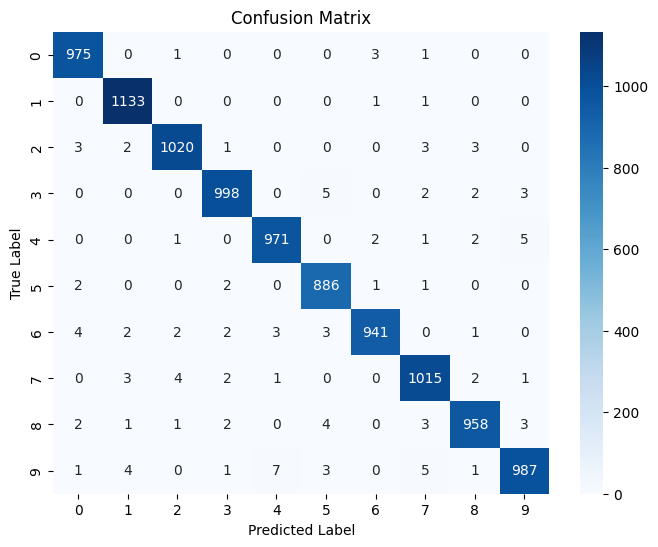

INFO :      fit progress: (20, 0.0005667658979073166, {'accuracy': 0.9883}, 3597.349172775008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 3598.15s
INFO :      	History (loss, distributed):
INFO :      		round 1: (1.5712874301252107, {'accuracy': 0.44043652115961346})
INFO :      		round 2: (5.456679349539876, {'accuracy': 0.3377207597467511})
INFO :      		round 3: (0.5973649949843349, {'accuracy': 0.8188937020993002})
INFO :      		round 4: (1.2137557506978374, {'accuracy': 0.678857047650783})
INFO :      		round 5: (0.7729707470747758, {'accuracy': 0.7661612795734755})
INFO :      		round 6: (1.2095666004097172, {'accuracy': 0.667777407530823})
INFO :      		round 7: (0.7971785718383332, {'accuracy': 0.7640786404531823})
INFO :      		round 8: (12.034120612126992, {'accuracy': 0.1242919026991003})
INFO :      		roun

(ClientAppActor pid=2314531) [Sun Jul 13 21:26:45 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
Total Training Time: 3631.06 seconds


In [11]:
# 讓 Flower 運行完整的 FL 訓練
start_time = time.time()  # 記錄開始時間

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

end_time = time.time()  # 記錄結束時間
total_time = end_time - start_time  # 計算總時間

print(f"Total Training Time: {total_time:.2f} seconds")  # 顯示總時間

### Loss 和 Accuracy 折線圖

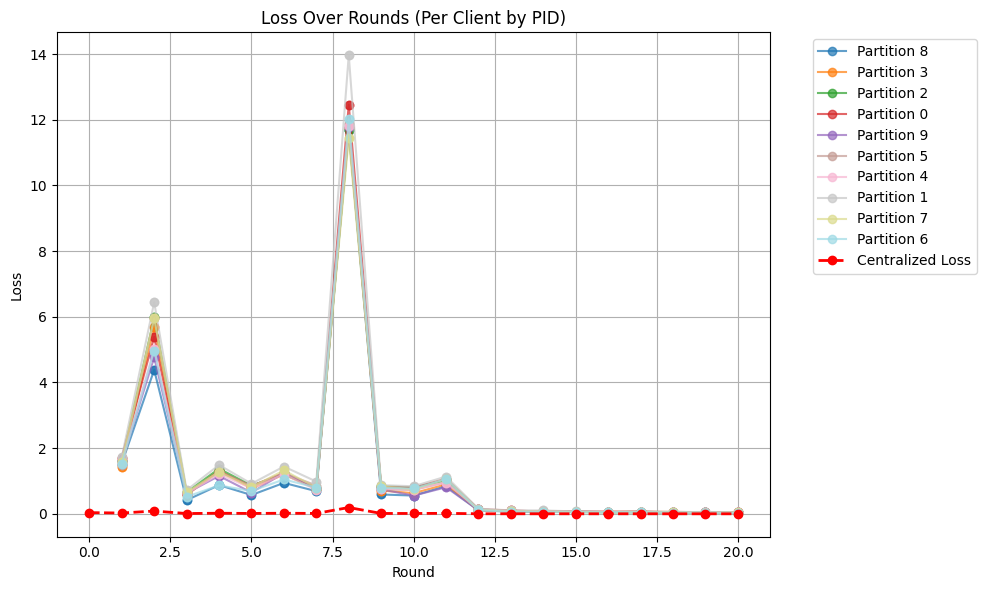

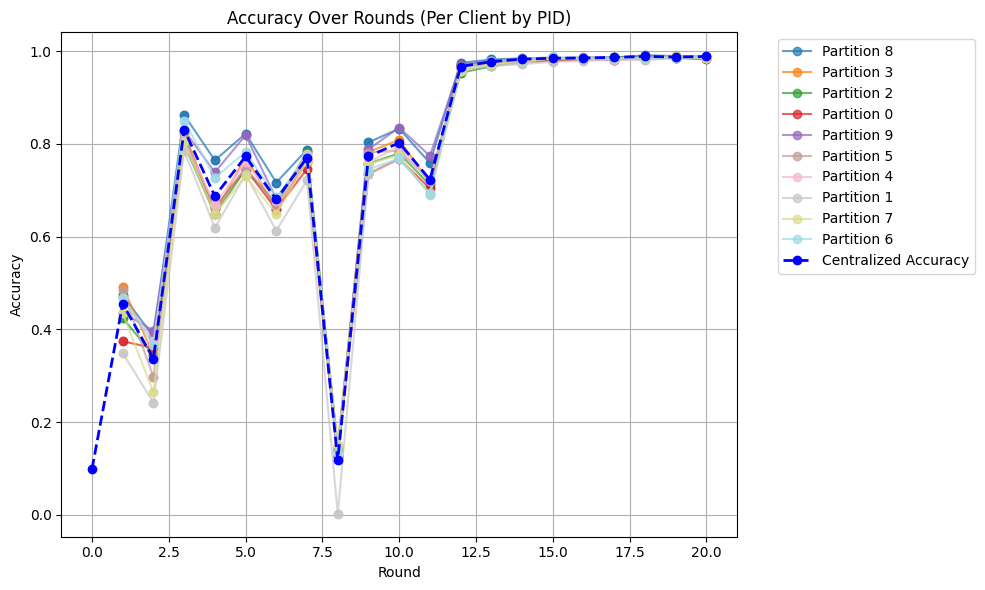

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 提取每個 client（按 pid）的 loss 和 accuracy 數據
client_losses = {}  # {pid: [(round, loss), ...]}
client_accuracies = {}  # {pid: [(round, acc), ...]}

for round_num, pid, loss in history.losses_distributed:
    if pid not in client_losses:
        client_losses[pid] = []
    client_losses[pid].append((round_num, loss))

for round_num, pid, acc in history.metrics_distributed.get('accuracy', []):
    if pid not in client_accuracies:
        client_accuracies[pid] = []
    client_accuracies[pid].append((round_num, acc))

# 為圖表生成隨機顏色
colors = plt.cm.tab20(np.linspace(0, 1, max(len(client_losses), len(client_accuracies))))

# 繪製每個 client 的 Loss 圖
plt.figure(figsize=(10, 6))
for idx, (pid, losses) in enumerate(client_losses.items()):
    rounds = [r for r, _ in sorted(losses)]
    loss_values = [l for _, l in sorted(losses)]
    plt.plot(rounds, loss_values, marker='o', color=colors[idx], label=f'Partition {pid}', alpha=0.7)

# 繪製 centralized 和 distributed loss
rounds_loss = [t[0] for t in history.losses_centralized]
loss_values_centralized = [t[1] for t in history.losses_centralized]

distributed_loss_by_round = {}
for round_num, _, loss in history.losses_distributed:
    if round_num not in distributed_loss_by_round:
        distributed_loss_by_round[round_num] = []
    distributed_loss_by_round[round_num].append(loss)
rounds_loss_distributed = sorted(distributed_loss_by_round.keys())
loss_values_distributed = [np.mean(distributed_loss_by_round[r]) for r in rounds_loss_distributed]

plt.plot(rounds_loss, loss_values_centralized, marker='o', color='red', label='Centralized Loss', linewidth=2, linestyle='--')
# plt.plot(rounds_loss_distributed, loss_values_distributed, marker='o', color='orange', label='Distributed Loss', linewidth=2, linestyle='--')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss Over Rounds (Per Client by PID)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 繪製每個 client 的 Accuracy 圖
plt.figure(figsize=(10, 6))
for idx, (pid, accuracies) in enumerate(client_accuracies.items()):
    rounds = [r for r, _ in sorted(accuracies)]
    acc_values = [a for _, a in sorted(accuracies)]
    plt.plot(rounds, acc_values, marker='o', color=colors[idx], label=f'Partition {pid}', alpha=0.7)

# 繪製 centralized 和 distributed accuracy
acc_rounds = [t[0] for t in history.metrics_centralized.get('accuracy', [])]
acc_values_centralized = [t[1] for t in history.metrics_centralized.get('accuracy', [])]

distributed_acc_by_round = {} 
for round_num, _, acc in history.metrics_distributed.get('accuracy', []):
    if round_num not in distributed_acc_by_round:
        distributed_acc_by_round[round_num] = []
    distributed_acc_by_round[round_num].append(acc)
acc_rounds_md = sorted(distributed_acc_by_round.keys())
acc_values_md = [np.mean(distributed_acc_by_round[r]) for r in acc_rounds_md]

plt.plot(acc_rounds, acc_values_centralized, marker='o', color='blue', label='Centralized Accuracy', linewidth=2, linestyle='--')
# plt.plot(acc_rounds_md, acc_values_md, marker='o', color='green', label='Distributed Accuracy', linewidth=2, linestyle='--')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Rounds (Per Client by PID)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

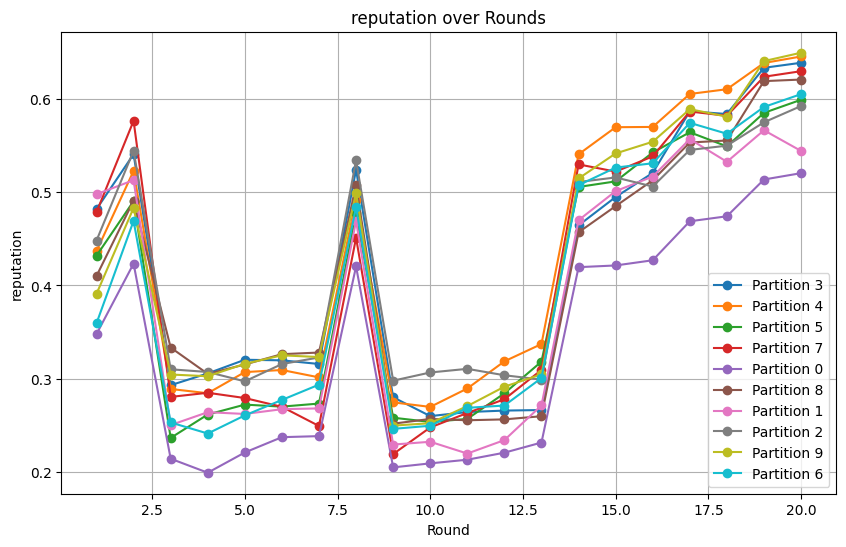

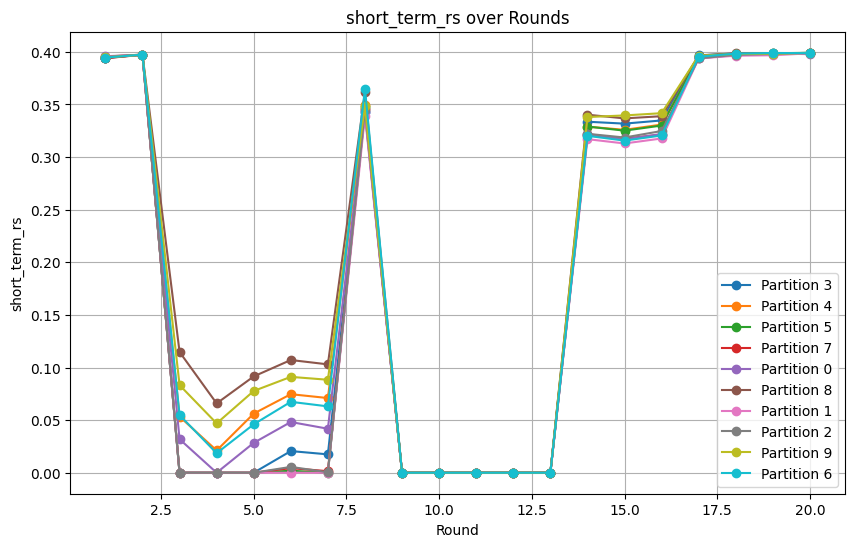

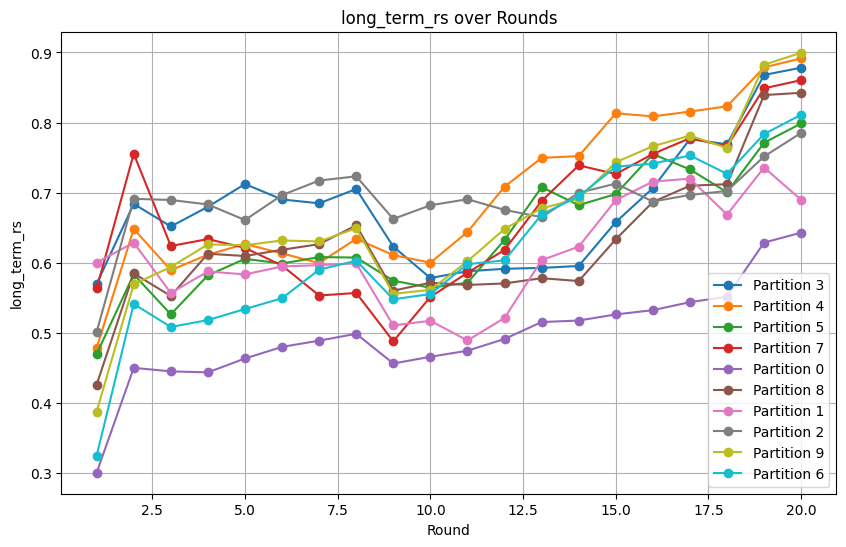

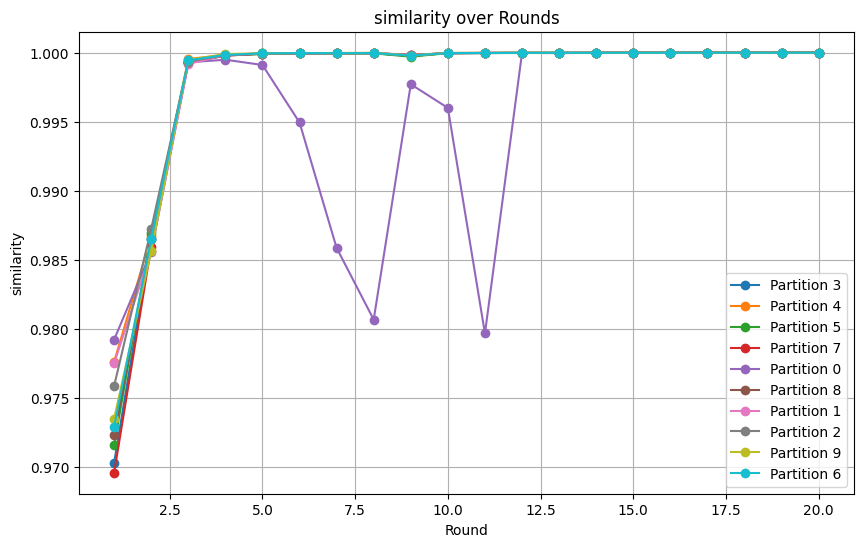

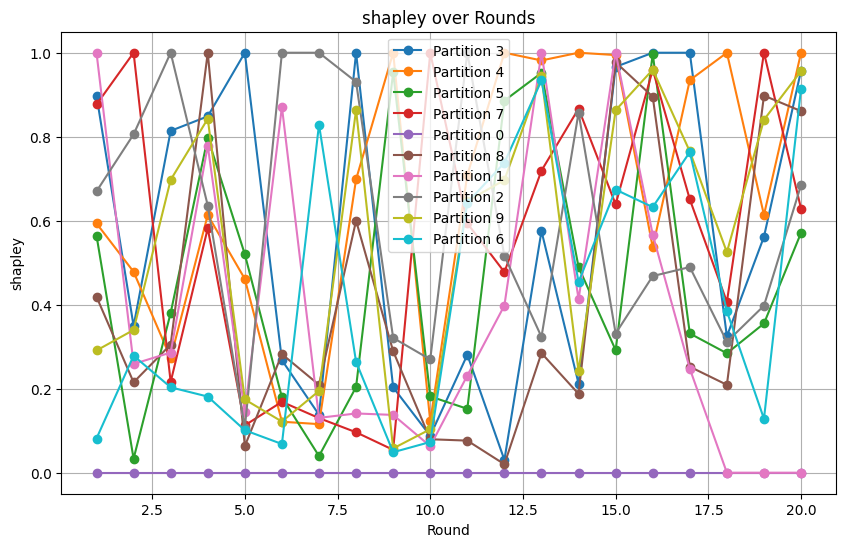

In [13]:
# ========= 訓練結束後繪圖 =========

# 假設 NUM_ROUNDS 為全局訓練輪數
rounds = list(range(1, NUM_ROUNDS + 1))
metrics_to_plot = ['reputation', 'short_term_rs', 'long_term_rs', 'similarity', 'shapley']

# 從策略中提取 metric_history
metric_history = strategy.metric_history

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for partition_id, metrics_dict in metric_history.items():
        # if partition_id == -1:
        #     continue
        values = metrics_dict[metric]
        # 若某 client 的紀錄少於 NUM_ROUNDS (代表部分 round 沒有更新)，則補上最後一次的值
        if len(values) < NUM_ROUNDS:
            last_val = values[-1] if values else 0.0
            values = values + [last_val] * (NUM_ROUNDS - len(values))
        plt.plot(rounds, values, marker='o', label=f'Partition {partition_id}')
    plt.xlabel('Round')
    plt.ylabel(metric)
    plt.title(f'{metric} over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
# history.metrics_centralized
best_epoch, best_accuracy = max(history.metrics_centralized['accuracy'], key=lambda x: x[1])

print(f"Best Epoch: {best_epoch}, Accuracy: {best_accuracy:.4f}")

Best Epoch: 18, Accuracy: 0.9884


In [15]:
import numpy as np

# 1. 從 history.losses_distributed 中整理出：{ round_num: [loss_client1, loss_client2, ...], ... }
accuracies_by_round = {}
for round_num, pid, loss in history.metrics_distributed.get('accuracy', []):
    if round_num not in accuracies_by_round:
        accuracies_by_round[round_num] = []
    accuracies_by_round[round_num].append(loss)

# 2. 按 round 排序，計算每一輪的 client_loss 標準差（母體標準差 ddof=0）
rounds = sorted(accuracies_by_round.keys())
fairness_std_per_round = []
for r in rounds:
    client_accuracies_this_round = accuracies_by_round[r]
    if len(client_accuracies_this_round) > 1:
        std_val = float(np.std(client_accuracies_this_round, ddof=0))
    else:
        std_val = 0.0  # 如果只有一個 client 或無資料，就設為 0
    fairness_std_per_round.append(std_val)


avg_fairness_std = float(np.mean(fairness_std_per_round))
# print("500 輪公平性標準差平均值：", avg_fairness_std)
# fairness_std_per_round

# 確定只考慮前500輪（若總輪次少於500，則全部都考慮）
num_rounds = min(500, len(fairness_std_per_round))
subset = fairness_std_per_round[:num_rounds]

# 取最小值
min_std = min(subset)

print(f"前 {num_rounds} 輪中，公平性標準差的最小值為：{min_std}")

前 20 輪中，公平性標準差的最小值為：0.001725282484935932


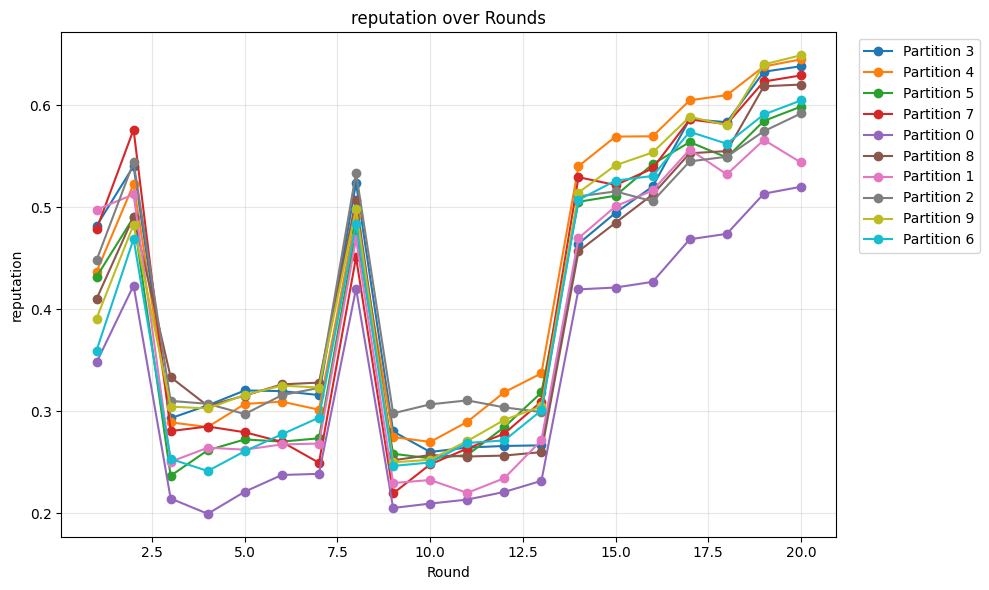

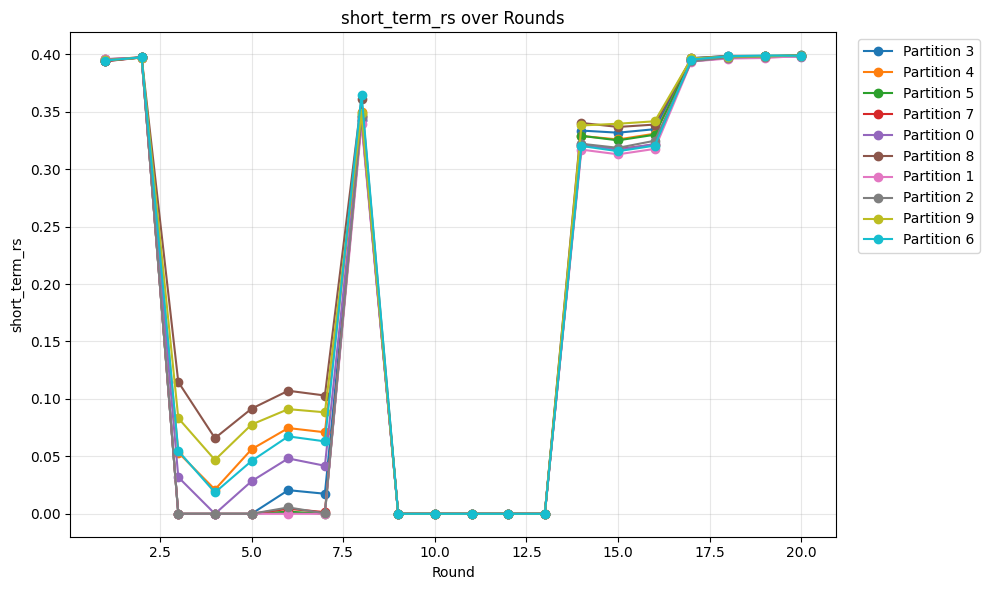

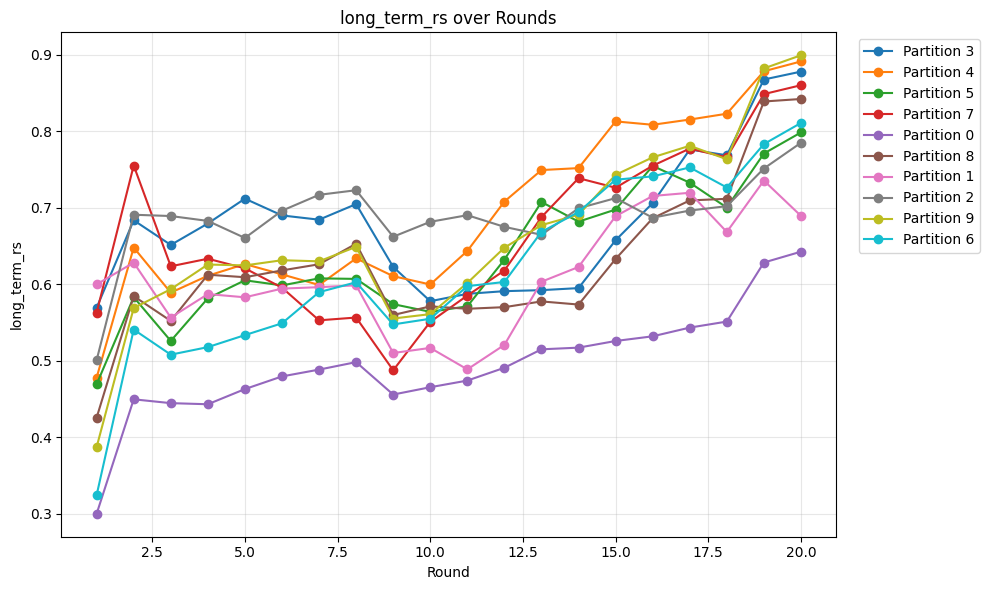

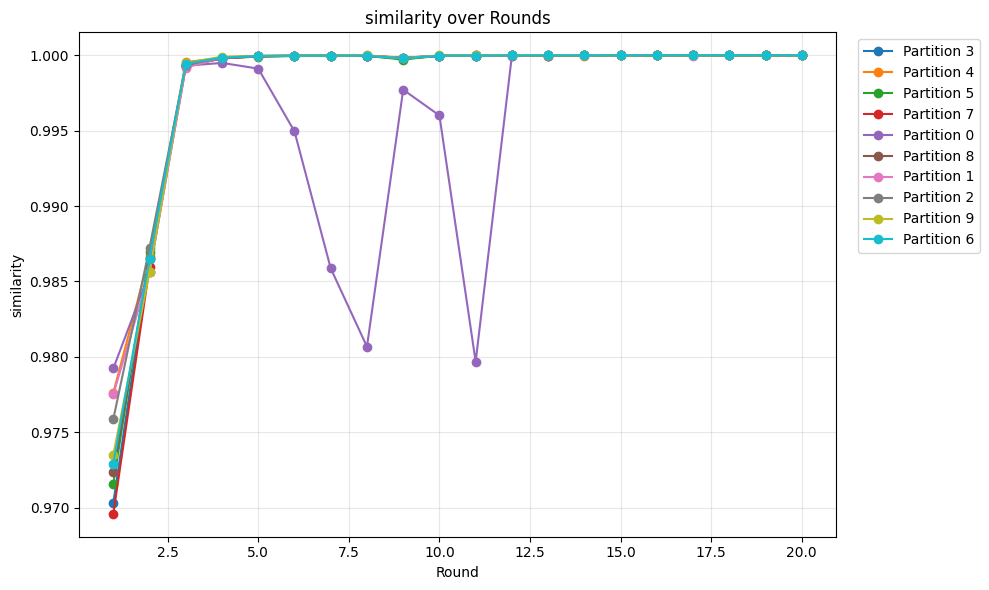

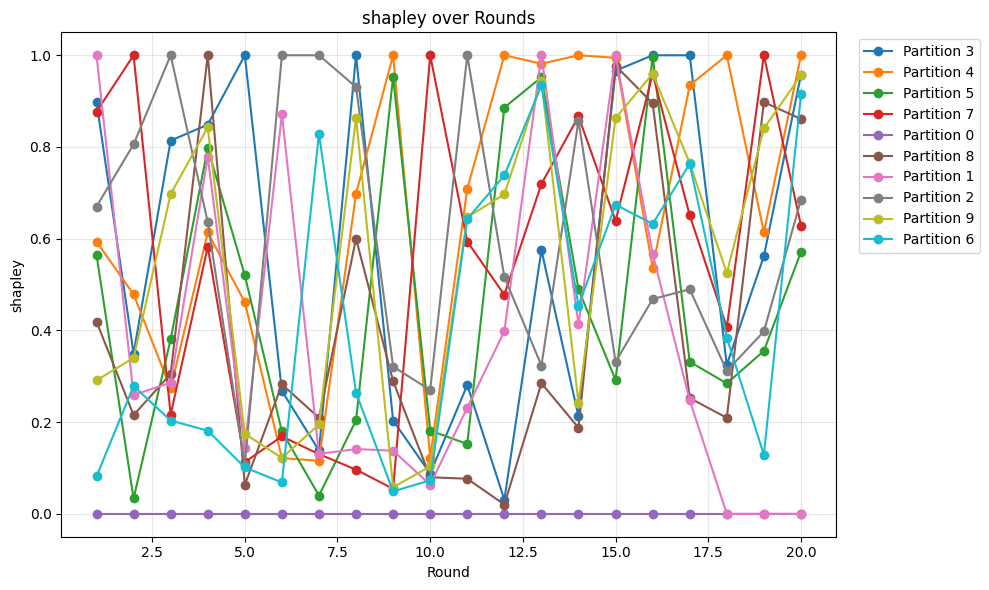

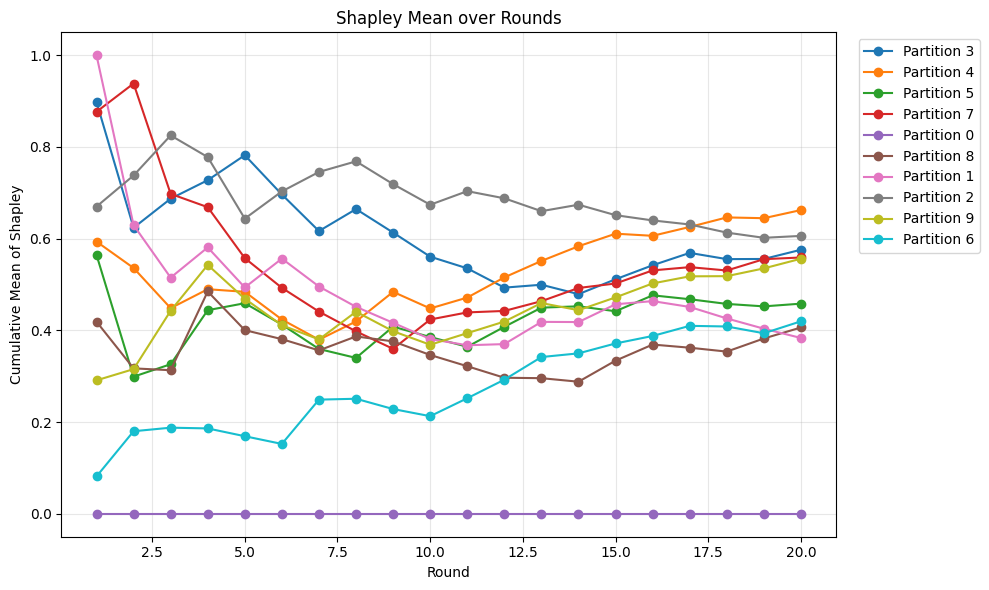

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 共同的 x-tick 刻度 ----------
tick_step = 2.5                              # 想要每 2.5 一格
xtick_vals = np.arange(tick_step, NUM_ROUNDS + tick_step, tick_step)

# ---------- 1. 五個原始指標 ----------
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for cid, m in metric_history.items():
        vals = m[metric]
        if len(vals) < NUM_ROUNDS:
            vals = vals + [vals[-1]] * (NUM_ROUNDS - len(vals))
        plt.plot(rounds, vals, marker='o', label=f'Partition {cid}')
    plt.title(f'{metric} over Rounds')
    plt.xlabel('Round');  plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.xticks(xtick_vals)                  # ← 只改這一行
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout();  plt.show()

# ---------- 2. Shapley「歷史均值」 ----------
plt.figure(figsize=(10, 6))
for cid, m in metric_history.items():
    vals = m['shapley']
    if len(vals) < NUM_ROUNDS:
        vals = vals + [vals[-1]] * (NUM_ROUNDS - len(vals))
    cum_mean = np.cumsum(vals) / np.arange(1, NUM_ROUNDS + 1)
    plt.plot(rounds, cum_mean, marker='o', label=f'Partition {cid}')

plt.title('Shapley Mean over Rounds')
plt.xlabel('Round');  plt.ylabel('Cumulative Mean of Shapley')
plt.grid(True, alpha=0.3)
plt.xticks(xtick_vals)                      # ← 同樣改這裡
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout();  plt.show()
